# Group Project: Final Report

##### Robert Aleman, Yanai Feldman, Huey Sun, Jacob Fontana

In [291]:
library(lattice)
library(xgboost)
library(bnstruct)
library(plyr)
library(ggplot2)
library(caTools)
library(caret)
library(pROC)

df <- read.csv("cs-training.csv")
df <- df[,2:length(df)]
head(df)

SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30.59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60.89DaysPastDueNotWorse,NumberOfDependents
1,0.7661266,45,2,0.80298213,9120,13,0,6,0,2
0,0.9571510,40,0,0.12187620,2600,4,0,0,0,1
0,0.6581801,38,1,0.08511338,3042,2,1,0,0,0
0,0.2338098,30,0,0.03604968,3300,5,0,0,0,0
0,0.9072394,49,1,0.02492570,63588,7,0,1,0,0
0,0.2131787,74,0,0.37560697,3500,3,0,1,0,1


Our task here is to design a binary classifier that can predict whether or not a potential borrower will default on their loan. We are given a dataset of 150,000 past borrowers, each labeled as to whether or not they had defaulted on their loan, along with 10 numeric variables about them. 

## Data Cleaning / Preprocessing 

First let's look at our predictor variable:

In [292]:
table(df[,1])
paste("Proportion:", mean(df[,1]))


     0      1 
139974  10026 

[1] "Proportion: 0.06684"

We can see that we're dealing with a moderate/large-sized class imbalance. Depending on the model, we may need to do some class balancing through undersample, oversampling, or some other balancing technique. But for now, we'll pause on this and look at our 10 features:

In [293]:
summary(df[,2:length(df)])

 RevolvingUtilizationOfUnsecuredLines      age       
 Min.   :    0.00                     Min.   :  0.0  
 1st Qu.:    0.03                     1st Qu.: 41.0  
 Median :    0.15                     Median : 52.0  
 Mean   :    6.05                     Mean   : 52.3  
 3rd Qu.:    0.56                     3rd Qu.: 63.0  
 Max.   :50708.00                     Max.   :109.0  
                                                     
 NumberOfTime30.59DaysPastDueNotWorse   DebtRatio        MonthlyIncome    
 Min.   : 0.000                       Min.   :     0.0   Min.   :      0  
 1st Qu.: 0.000                       1st Qu.:     0.2   1st Qu.:   3400  
 Median : 0.000                       Median :     0.4   Median :   5400  
 Mean   : 0.421                       Mean   :   353.0   Mean   :   6670  
 3rd Qu.: 0.000                       3rd Qu.:     0.9   3rd Qu.:   8249  
 Max.   :98.000                       Max.   :329664.0   Max.   :3008750  
                                           

We also used histogram and density plots (omitted from the final report) can see just from a quick glance at our data's interquartile ranges (IQR) that we are dealing with major outliers for most our features. Two of our features, MonthlyIncome and NumberOfDependents, have missing values that will require imputation. We tackled our data cleaning and feature engineering one column at a time. 

### Age

Looking at the value counts and IQR for age:

In [294]:
summary(df$age)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    0.0    41.0    52.0    52.3    63.0   109.0 

In [295]:
table(df$age)


   0   21   22   23   24   25   26   27   28   29   30   31   32   33   34   35 
   1  183  434  641  816  953 1193 1338 1560 1702 1937 2038 2050 2239 2155 2246 
  36   37   38   39   40   41   42   43   44   45   46   47   48   49   50   51 
2379 2521 2631 2987 3093 3122 3082 3208 3294 3502 3714 3719 3806 3837 3753 3627 
  52   53   54   55   56   57   58   59   60   61   62   63   64   65   66   67 
3609 3648 3561 3416 3589 3375 3443 3280 3258 3522 3568 3719 3058 2594 2494 2503 
  68   69   70   71   72   73   74   75   76   77   78   79   80   81   82   83 
2235 1954 1777 1646 1649 1520 1451 1241 1183 1099 1054  981  876  774  647  512 
  84   85   86   87   88   89   90   91   92   93   94   95   96   97   98   99 
 480  483  407  357  313  276  198  154   93   87   47   45   18   17    6    9 
 101  102  103  105  107  109 
   3    3    3    1    1    2 

Age tends to have a somewhat reasonable distribution. There are a suspicious number of centenarians in my opinion but I guess they're sufficiently plausible to avoid modifying them. The only certainly incorrect data is that there is one person in the dataset with age 0, and because infants are not legally permitted to take out loans, we will impute that to the next youngest person in the dataset.

In [296]:
df[df$age == 0,]$age <- min(df[df$age > 0,]$age)

## Monthly Income

In [297]:
summary( df$MonthlyIncome )

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
      0    3400    5400    6670    8249 3008750   29731 

MonthlyIncome has nearly 30,000 missing values, and at 20% of the dataset, that's a lot of missing information. But there may be a reason for these missing values. We checked to see if the people with missing MonthlyIncome values have any special properties:

In [298]:
summary ( df[is.na(df$MonthlyIncome),] )

 SeriousDlqin2yrs  RevolvingUtilizationOfUnsecuredLines      age        
 Min.   :0.00000   Min.   :    0.000                    Min.   : 21.00  
 1st Qu.:0.00000   1st Qu.:    0.016                    1st Qu.: 46.00  
 Median :0.00000   Median :    0.082                    Median : 57.00  
 Mean   :0.05614   Mean   :    6.649                    Mean   : 56.36  
 3rd Qu.:0.00000   3rd Qu.:    0.441                    3rd Qu.: 67.00  
 Max.   :1.00000   Max.   :22198.000                    Max.   :109.00  
                                                                        
 NumberOfTime30.59DaysPastDueNotWorse   DebtRatio      MonthlyIncome  
 Min.   : 0.0000                      Min.   :     0   Min.   : NA    
 1st Qu.: 0.0000                      1st Qu.:   123   1st Qu.: NA    
 Median : 0.0000                      Median :  1159   Median : NA    
 Mean   : 0.5799                      Mean   :  1673   Mean   :NaN    
 3rd Qu.: 0.0000                      3rd Qu.:  2382   3rd Qu

Wow, it looks like the DebtRatio is significantly higher for those with missing incomes (a median DebtRatio of over 1,000!). This makes sense because DebtRatio is calculated as the amount of debt someone has divided by their income, so if they have a trivial income, we can expect abnormally high DebtRatios. Additionally, we later observed that out of those with high DebtRatios that didn't have missing MonthlyIncomes, their MonthlyIncomes were zero or near-zero. Our likely hypothesis is that missing MonthlyIncome values came from borrowers who left that field blank because they had low or no income. If we go with this theory, then one option is to just impute these missing values with zero.

In [299]:
# Option 1
ImputeMonthlyIncomeWithZeroForAll <- function(df) {
    df[is.na(df$MonthlyIncome),]$MonthlyIncome <- 0
    return(df)
}

Another option for imputation is to use some regression model to fill in missing data. We chose a k-nearest neighbors imputer which looks at the other 9 variables and uses them to predict the missing values. We ran a quick knn model and saved our results. We then can impute by loading the regression results into our MonthlyIncome column.

In [300]:
# NOTE: this code only needs to be executed on first run; subsequent runs can just load the impute calculations
#data_imputed <- knn.impute(df,k=10,cat.var = c(1,4,7:11), to.impute = 1:nrow(df), using = 1:nrow(df))
#write.csv(data_imputed, "data_imputed.csv") # save for quick retrieval for future runs

In [301]:
# Option 2
ImputeMonthlyIncomeWithKNNOnly <- function(df) {
    data_imputed <- read.csv("data_imputed.csv")
    df$MonthlyIncome <- data_imputed$MonthlyIncome
    return (df)
}

Our third (and favorite) option was to use a hybrid of both: this imputer would first impute monthly incomes with sufficiently high debt ratios as zero, and then would use the KNN imputation for the rest of the missing values.

In [302]:
# Option 3
ImputeMonthlyIncomeWithZeroForHighDR <- function(df) {
    df[df$DebtRatio > 150,]$MonthlyIncome <- 0
    return (df)
}

## Number of Dependents

In [304]:
summary(df$NumberOfDependents)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
  0.000   0.000   0.000   0.757   1.000  20.000    3924 

In [305]:
table(df$NumberOfDependents)


    0     1     2     3     4     5     6     7     8     9    10    13    20 
86902 26316 19522  9483  2862   746   158    51    24     5     5     1     1 

The other variable with missing values was NumberOfDependents. There are about 4,000 missing values here (~2% of the dataset). Similar to MonthlyIncome, we can do a quick scan of the dataset of people with missing NumberOfDependents to see if they have any special properties:

In [306]:
summary ( df[is.na(df$NumberOfDependents),] )

 SeriousDlqin2yrs  RevolvingUtilizationOfUnsecuredLines      age        
 Min.   :0.00000   Min.   :    0.000                    Min.   : 21.00  
 1st Qu.:0.00000   1st Qu.:    0.008                    1st Qu.: 48.00  
 Median :0.00000   Median :    0.047                    Median : 61.00  
 Mean   :0.04562   Mean   :   10.745                    Mean   : 59.59  
 3rd Qu.:0.00000   3rd Qu.:    0.268                    3rd Qu.: 74.00  
 Max.   :1.00000   Max.   :10821.000                    Max.   :109.00  
                                                                        
 NumberOfTime30.59DaysPastDueNotWorse   DebtRatio      MonthlyIncome 
 Min.   : 0.0000                      Min.   :     0   Min.   : NA   
 1st Qu.: 0.0000                      1st Qu.:    21   1st Qu.: NA   
 Median : 0.0000                      Median :   358   Median : NA   
 Mean   : 0.9083                      Mean   :  1084   Mean   :NaN   
 3rd Qu.: 0.0000                      3rd Qu.:  1559   3rd Qu.: NA

Since all of the people with missing NumberOfDependents also have a missing MonthlyIncome, their DebtRatio is high as well. But other than that, they don't seem to have anything particularly unusual. So if we do an imputation, it would make most sense just to impute with regards to some central tendency. We have a couple options here: one, we could impute with the median. But since the median is zero, it's possible that this could undershoot the true number of dependents. We could try the mean as well. And finally, we could also bring out the KNN imputer.

In [307]:
# Option 1: Impute with median (zero)
ImputeDependentsWithZero <- function(df) {
    df[is.na(df$NumberOfDependents),]$NumberOfDependents <- 0
    return (df)
}

# Option 2: Impute with mean
ImputeNumberOfDependentsMean <- function(df){
  df[is.na(df$NumberOfDependents), ]$NumberOfDependents <- mean(na.omit(df$NumberOfDependents))
  return(df)
}

# Option 3: Impute with KNN
ImputeDependentsWithKNN <- function(df) {
    data_imputed <- read.csv("data_imputed.csv")
    df$NumberOfDependents <- data_imputed$NumberOfDependents
    return (df)
}

## RevolvingUtilizationOfUnsecuredLines

In [308]:
summary ( df$RevolvingUtilizationOfUnsecuredLines )

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
    0.00     0.03     0.15     6.05     0.56 50708.00 

No missing or incorrect values for RevolvingUtilizationOfUnsecuredLines - however, there is a very notable amount of extremely high outliers. In fact, the mean of our data is higher than our 99th percentile. These could skew our model. To quickly check if there are any special propreties of those individuals with very high RevolvingUtilizationOfUnsecuredLines:

In [309]:
length(df[df$RevolvingUtilizationOfUnsecuredLines >= 100,][,1])
summary ( df[df$RevolvingUtilizationOfUnsecuredLines >= 100,] )

[1] 223

 SeriousDlqin2yrs  RevolvingUtilizationOfUnsecuredLines      age       
 Min.   :0.00000   Min.   :  112                        Min.   :24.00  
 1st Qu.:0.00000   1st Qu.: 1082                        1st Qu.:39.00  
 Median :0.00000   Median : 2159                        Median :48.00  
 Mean   :0.04933   Mean   : 3848                        Mean   :50.59  
 3rd Qu.:0.00000   3rd Qu.: 4318                        3rd Qu.:62.50  
 Max.   :1.00000   Max.   :50708                        Max.   :87.00  
                                                                       
 NumberOfTime30.59DaysPastDueNotWorse   DebtRatio         MonthlyIncome  
 Min.   :0.00                         Min.   :    0.001   Min.   :    0  
 1st Qu.:0.00                         1st Qu.:    0.213   1st Qu.: 4800  
 Median :0.00                         Median :    0.381   Median : 7083  
 Mean   :0.13                         Mean   :  604.614   Mean   : 8629  
 3rd Qu.:0.00                         3rd Qu.:   81.50

These individuals don't appear to have any special properties outside of the rest of the dataset, so we can help by trimming the outliers. We have a few options: either we can either trim our outliers (ie, get rid of them entirely), convert these outliers to the median, or we can perform Winsorization, the process of converting all values above a certain range to some Nth percentile.

In [310]:
TrimHighRevolvingUtilToMedian <- function(df){
  df[df$RevolvingUtilizationOfUnsecuredLines>100,]$RevolvingUtilizationOfUnsecuredLines<- median(df$RevolvingUtilizationOfUnsecuredLines)
  return(df)
}

In [311]:
WinsorizeHighRevolvingUtil <- function(df, qtile){
  s <- seq(1, (1-qtile)*nrow(df), 1)
  sorted <- df[order(df$RevolvingUtilizationOfUnsecuredLines),]
  trim.max <- max(sorted$RevolvingUtilizationOfUnsecuredLines[s])
  df[df$RevolvingUtilizationOfUnsecuredLines > trim.max, ]$RevolvingUtilizationOfUnsecuredLines <- trim.max
  return (df)
}

## DebtRatio

In [312]:
summary ( df$DebtRatio )

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
     0.0      0.2      0.4    353.0      0.9 329664.0 

We explained the DebtRatio outliers with MonthlyIncome, and how these individuals with extremely high DebtRatios just have no/minimal income. For the sake of a cleaner model, it could help to trim these outliers as well.

In [313]:
WinsorizeDebtRatio <- function(df, qtile){
  s <- seq(1, (1-qtile)*nrow(df), 1)
  sorted <- df[order(df$DebtRatio),]
  trim.max <- max(sorted$DebtRatio[s])
  df[df$DebtRatio > trim.max, ]$DebtRatio <- trim.max
  return (df)
}

## Number of Days Past Due 

In [314]:
table(df$NumberOfTime30.59DaysPastDueNotWorse)


     0      1      2      3      4      5      6      7      8      9     10 
126018  16033   4598   1754    747    342    140     54     25     12      4 
    11     12     13     96     98 
     1      2      1      5    264 

In [315]:
table(df$NumberOfTime60.89DaysPastDueNotWorse)


     0      1      2      3      4      5      6      7      8      9     11 
142396   5731   1118    318    105     34     16      9      2      1      1 
    96     98 
     5    264 

In [316]:
table(df$NumberOfTimes90DaysLate)


     0      1      2      3      4      5      6      7      8      9     10 
141662   5243   1555    667    291    131     80     38     21     19      8 
    11     12     13     14     15     17     96     98 
     5      2      4      2      2      1      5    264 

Upon a first look at the IQRs of these three variables, we initially thought that there were just outliers in these three datasets. However, looking above, it seems that 96 or 98 are chosen exactly the same for all three categories of days late. Let's see what properties these have:

In [317]:
summary(df[df$NumberOfTime30.59DaysPastDueNotWorse>95,])

 SeriousDlqin2yrs RevolvingUtilizationOfUnsecuredLines      age       
 Min.   :0.0000   Min.   :1                            Min.   :21.00  
 1st Qu.:0.0000   1st Qu.:1                            1st Qu.:24.00  
 Median :1.0000   Median :1                            Median :29.00  
 Mean   :0.5465   Mean   :1                            Mean   :34.25  
 3rd Qu.:1.0000   3rd Qu.:1                            3rd Qu.:43.00  
 Max.   :1.0000   Max.   :1                            Max.   :79.00  
                                                                      
 NumberOfTime30.59DaysPastDueNotWorse   DebtRatio      MonthlyIncome  
 Min.   :96.00                        Min.   :  0.00   Min.   :    0  
 1st Qu.:98.00                        1st Qu.:  0.00   1st Qu.: 1333  
 Median :98.00                        Median :  0.00   Median : 2168  
 Mean   :97.96                        Mean   :  5.74   Mean   : 2557  
 3rd Qu.:98.00                        3rd Qu.:  0.00   3rd Qu.: 3174  
 Max. 

Looking above, it appears that any row that has values of 96 or 98 for their PastDue column will also have that same value marked for the rest of the PastDue categories. More importantly, these values have a mean SeriousDlqin2yrs of 0.54. This is close to 10x the probability of the sample dataset. This has enormous predictive power if these types of values are also present in the testing data. 

We want to be able to harness the predictive power of these values, so before we impute, we will augment our feature space by making a special binary column marking each rows that have a 96 or 98 in the PastDue columns. That makes sure we still can capture this signal even when we impute the data. We still need to impute the data here even with some useful signal because the 96 and 98 values are outliers in the context of the rest of the values in the three PastDue columns.

There are a couple different options to impute them. We can either impute them with the max (technically we could also use Winsorization but might not be super necessary considering there aren't really any other outliers besides the 96 and 98 values), or if we feel these datapoints are more representative of the median we could impute these at the median.

In [318]:
# Option 1
ImputeWeirdPastDueWithMax <- function(df) {
    df[df$NumberOfTime30.59DaysPastDueNotWorse > 95,]$NumberOfTime30.59DaysPastDueNotWorse <- NA
    df[is.na(df$NumberOfTime30.59DaysPastDueNotWorse),]$NumberOfTime30.59DaysPastDueNotWorse <- max( na.omit(df$NumberOfTime30.59DaysPastDueNotWorse))
    df[df$NumberOfTime60.89DaysPastDueNotWorse > 95,]$NumberOfTime60.89DaysPastDueNotWorse <- NA
    df[is.na(df$NumberOfTime60.89DaysPastDueNotWorse),]$NumberOfTime60.89DaysPastDueNotWorse <- max(na.omit(df$NumberOfTime60.89DaysPastDueNotWorse))
    df[df$NumberOfTimes90DaysLate > 95,]$NumberOfTimes90DaysLate <- NA
    df[is.na(df$NumberOfTimes90DaysLate),]$NumberOfTimes90DaysLate <- max(na.omit(df$NumberOfTimes90DaysLate))
    return (df)
}

In [319]:
# Option 2
ImputeWeirdPastDueWithMedian <- function(df) {
    df[df$NumberOfTime30.59DaysPastDueNotWorse > 95,]$NumberOfTime30.59DaysPastDueNotWorse <- NA
    df[is.na(df$NumberOfTime30.59DaysPastDueNotWorse),]$NumberOfTime30.59DaysPastDueNotWorse <- median( na.omit(df$NumberOfTime30.59DaysPastDueNotWorse))
    df[df$NumberOfTime60.89DaysPastDueNotWorse > 95,]$NumberOfTime60.89DaysPastDueNotWorse <- NA
    df[is.na(df$NumberOfTime60.89DaysPastDueNotWorse),]$NumberOfTime60.89DaysPastDueNotWorse <- median(na.omit(df$NumberOfTime60.89DaysPastDueNotWorse))
    df[df$NumberOfTimes90DaysLate > 95,]$NumberOfTimes90DaysLate <-NA
    df[is.na(df$NumberOfTimes90DaysLate),]$NumberOfTimes90DaysLate <- median(na.omit(df$NumberOfTimes90DaysLate))
    return (df)
}

In [320]:
# Option 3
ImputeWeirdPastDueToNA <- function(df) {
    df[df$NumberOfTime30.59DaysPastDueNotWorse > 95,]$NumberOfTime30.59DaysPastDueNotWorse <- NA
    df[df$NumberOfTime60.89DaysPastDueNotWorse > 95,]$NumberOfTime60.89DaysPastDueNotWorse <- NA
    df[df$NumberOfTimes90DaysLate > 95,]$NumberOfTimes90DaysLate <-NA
    return (df)
}

# Feature Engineering

We haven't ran our imputation and cleaning functions on our data yet, but we have set them up. That's because before we impute, we want to see if we can dig out more signal from our dataset by creating new features out of our pre-existing ones. These can include transformations of our initial features, combinations of our initial features, transformations of combinations of our features, or adding in outside information. 

The easiest features to add are just common binary cases that may have a lot of predictive power. Some examples are:

In [321]:
AddFeatures <- function(df) {
    df$NoDebt <- as.numeric(df$DebtRatio == 0)
    df$VeryHighDebtRatio <- as.numeric(df$DebtRatio  >= 1 & df$DebtRatio < 10)
    df$ExtremelyHighDebtRatio <- as.numeric(df$DebtRatio  >= 100)

    df$NoRevolvingUtilization <- as.numeric ( df$RevolvingUtilizationOfUnsecuredLines == 0 )
    df$HighRevolvingUtilization <- as.numeric ( df$RevolvingUtilizationOfUnsecuredLines >= 1 )

    df$WeirdPastDue <- as.numeric ( df$NumberOfTime30.59DaysPastDueNotWorse > 95 )
    df$NeverPastDue <- as.numeric ( df$NumberOfTime30.59DaysPastDueNotWorse == 0 & 
                                    df$NumberOfTime60.89DaysPastDueNotWorse==0 & 
                                    df$NumberOfTimes90DaysLate ==0 )
    
    return ( df )
}

# Selecting Combinations of Imputation Methods

We created a lot of different methods of imputation because we weren't really sure which could be the best method. With 1 to 3 reasonable methods of imputation for most every feature, there's a ton of combinations that we could try. We decided to try them all of the reasonable methods out, and let cross validation decide which one will perform best.

In [263]:
df.test <- df
df.test <- AddFeatures ( df.test )
df.test <- ImputeMonthlyIncomeWithZeroForHighDR ( df.test )
df.test <- ImputeDependentsWithZero ( df.test )   # ImputeNumberOfDependentsMean
df.test <- WinsorizeHighRevolvingUtil( df.test, 0.02 ) 
df.test <- WinsorizeDebtRatio( df.test, 0.005 )
df.test <- ImputeWeirdPastDueWithMax( df.test )
df.test <- ExpandFeatureSpace ( df.test )
write.csv(df.test, "cleanData1.csv")

In [264]:
df.test <- df
df.test <- AddFeatures ( df.test )
df.test <- ImputeMonthlyIncomeWithZeroForAll ( df.test )
df.test <- ImputeDependentsWithZero ( df.test )   # ImputeNumberOfDependentsMean
df.test <- WinsorizeHighRevolvingUtil( df.test, 0.02 ) 
df.test <- WinsorizeDebtRatio( df.test, 0.15 )
df.test <- ImputeWeirdPastDueWithMax( df.test )
df.test <- ExpandFeatureSpace ( df.test )
write.csv(df.test, "cleanData2.csv")

In [265]:
df.test <- df
df.test <- AddFeatures ( df.test )
df.test <- ImputeMonthlyIncomeWithKNNOnly ( df.test )
df.test <- ImputeDependentsWithZero ( df.test )   # ImputeNumberOfDependentsMean
df.test <- WinsorizeHighRevolvingUtil( df.test, 0.02 ) 
df.test <- WinsorizeDebtRatio( df.test, 0.15 )
df.test <- ImputeWeirdPastDueWithMax( df.test )
df.test <- ExpandFeatureSpace ( df.test )
write.csv(df.test, "cleanData3.csv")

In [266]:
df.test <- df
df.test <- AddFeatures ( df.test )
df.test <- ImputeMonthlyIncomeWithZeroForHighDR ( df.test )
df.test <- ImputeNumberOfDependentsMean ( df.test )
df.test <- WinsorizeHighRevolvingUtil( df.test, 0.02 ) 
df.test <- WinsorizeDebtRatio( df.test, 0.15 )
df.test <- ImputeWeirdPastDueWithMax( df.test )
df.test <- ExpandFeatureSpace ( df.test )
write.csv(df.test, "cleanData4.csv")

In [267]:
df.test <- df
df.test <- AddFeatures ( df.test )
df.test <- ImputeMonthlyIncomeWithZeroForAll ( df.test )
df.test <- ImputeNumberOfDependentsMean ( df.test )
df.test <- WinsorizeHighRevolvingUtil( df.test, 0.02 ) 
df.test <- WinsorizeDebtRatio( df.test, 0.15 )
df.test <- ImputeWeirdPastDueWithMax( df.test )
df.test <- ExpandFeatureSpace ( df.test )
write.csv(df.test, "cleanData5.csv")

In [268]:
df.test <- df
df.test <- AddFeatures ( df.test )
df.test <- ImputeMonthlyIncomeWithKNNOnly ( df.test )
df.test <- ImputeNumberOfDependentsMean ( df.test )
df.test <- WinsorizeHighRevolvingUtil( df.test, 0.02 ) 
df.test <- WinsorizeDebtRatio( df.test, 0.15 )
df.test <- ImputeWeirdPastDueWithMax( df.test )
df.test <- ExpandFeatureSpace ( df.test )
write.csv(df.test, "cleanData6.csv")

In [269]:
df.test <- df
df.test <- AddFeatures ( df.test )
df.test <- ImputeMonthlyIncomeWithZeroForHighDR ( df.test )
df.test <- ImputeDependentsWithZero ( df.test )   # ImputeNumberOfDependentsMean
df.test <- TrimHighRevolvingUtilToMedian( df.test ) 
df.test <- WinsorizeDebtRatio( df.test, 0.15 )
df.test <- ImputeWeirdPastDueWithMax( df.test )
df.test <- ExpandFeatureSpace ( df.test )
write.csv(df.test, "cleanData7.csv")

In [270]:
df.test <- df
df.test <- AddFeatures ( df.test )
df.test <- ImputeMonthlyIncomeWithZeroForAll ( df.test )
df.test <- ImputeDependentsWithZero ( df.test )   # ImputeNumberOfDependentsMean
df.test <- TrimHighRevolvingUtilToMedian( df.test ) 
df.test <- WinsorizeDebtRatio( df.test, 0.15 )
df.test <- ImputeWeirdPastDueWithMax( df.test )
df.test <- ExpandFeatureSpace ( df.test )
write.csv(df.test, "cleanData8.csv")

In [271]:
df.test <- df
df.test <- AddFeatures ( df.test )
df.test <- ImputeMonthlyIncomeWithKNNOnly ( df.test )
df.test <- ImputeDependentsWithZero ( df.test )   # ImputeNumberOfDependentsMean
df.test <- TrimHighRevolvingUtilToMedian( df.test ) 
df.test <- WinsorizeDebtRatio( df.test, 0.15 )
df.test <- ImputeWeirdPastDueWithMax( df.test )
df.test <- ExpandFeatureSpace ( df.test )
write.csv(df.test, "cleanData9.csv")

In [272]:
df.test <- df
df.test <- AddFeatures ( df.test )
df.test <- ImputeMonthlyIncomeWithZeroForHighDR ( df.test )
df.test <- ImputeNumberOfDependentsMean ( df.test )
df.test <- TrimHighRevolvingUtilToMedian( df.test ) 
df.test <- WinsorizeDebtRatio( df.test, 0.15 )
df.test <- ImputeWeirdPastDueWithMax( df.test )
df.test <- ExpandFeatureSpace ( df.test )
write.csv(df.test, "cleanData10.csv")

In [273]:
df.test <- df
df.test <- AddFeatures ( df.test )
df.test <- ImputeMonthlyIncomeWithZeroForAll ( df.test )
df.test <- ImputeNumberOfDependentsMean ( df.test )
df.test <- TrimHighRevolvingUtilToMedian( df.test ) 
df.test <- WinsorizeDebtRatio( df.test, 0.15 )
df.test <- ImputeWeirdPastDueWithMax( df.test )
df.test <- ExpandFeatureSpace ( df.test )
write.csv(df.test, "cleanData11.csv")

In [274]:
df.test <- df
df.test <- AddFeatures ( df.test )
df.test <- ImputeMonthlyIncomeWithKNNOnly ( df.test )
df.test <- ImputeNumberOfDependentsMean ( df.test )
df.test <- TrimHighRevolvingUtilToMedian( df.test ) 
df.test <- WinsorizeDebtRatio( df.test, 0.15 )
df.test <- ImputeWeirdPastDueWithMax( df.test )
df.test <- ExpandFeatureSpace ( df.test )
write.csv(df.test, "cleanData12.csv")

In [275]:
df.test <- df
df.test <- AddFeatures ( df.test )
df.test <- ImputeMonthlyIncomeWithZeroForHighDR ( df.test )
df.test <- ImputeDependentsWithZero ( df.test )   # ImputeNumberOfDependentsMean
df.test <- WinsorizeHighRevolvingUtil( df.test, 0.02 ) 
df.test <- WinsorizeDebtRatio( df.test, 0.15 )
df.test <- ImputeWeirdPastDueWithMedian( df.test )
df.test <- ExpandFeatureSpace ( df.test )
write.csv(df.test, "cleanData13.csv")

In [276]:
df.test <- df
df.test <- AddFeatures ( df.test )
df.test <- ImputeMonthlyIncomeWithZeroForAll ( df.test )
df.test <- ImputeDependentsWithZero ( df.test )   # ImputeNumberOfDependentsMean
df.test <- WinsorizeHighRevolvingUtil( df.test, 0.02 ) 
df.test <- WinsorizeDebtRatio( df.test, 0.15 )
df.test <- ImputeWeirdPastDueWithMedian( df.test )
df.test <- ExpandFeatureSpace ( df.test )
write.csv(df.test, "cleanData14.csv")

In [277]:
df.test <- df
df.test <- AddFeatures ( df.test )
df.test <- ImputeMonthlyIncomeWithKNNOnly ( df.test )
df.test <- ImputeDependentsWithZero ( df.test )   # ImputeNumberOfDependentsMean
df.test <- WinsorizeHighRevolvingUtil( df.test, 0.02 ) 
df.test <- WinsorizeDebtRatio( df.test, 0.15 )
df.test <- ImputeWeirdPastDueWithMedian( df.test )
df.test <- ExpandFeatureSpace ( df.test )
write.csv(df.test, "cleanData15.csv")

In [278]:
df.test <- df
df.test <- AddFeatures ( df.test )
df.test <- ImputeMonthlyIncomeWithZeroForHighDR ( df.test )
df.test <- ImputeNumberOfDependentsMean ( df.test )
df.test <- WinsorizeHighRevolvingUtil( df.test, 0.02 ) 
df.test <- WinsorizeDebtRatio( df.test, 0.15 )
df.test <- ImputeWeirdPastDueWithMedian( df.test )
df.test <- ExpandFeatureSpace ( df.test )
write.csv(df.test, "cleanData16.csv")

In [279]:
df.test <- df
df.test <- AddFeatures ( df.test )
df.test <- ImputeMonthlyIncomeWithZeroForAll ( df.test )
df.test <- ImputeNumberOfDependentsMean ( df.test )
df.test <- WinsorizeHighRevolvingUtil( df.test, 0.02 ) 
df.test <- WinsorizeDebtRatio( df.test, 0.15 )
df.test <- ImputeWeirdPastDueWithMedian( df.test )
df.test <- ExpandFeatureSpace ( df.test )
write.csv(df.test, "cleanData17.csv")

In [280]:
df.test <- df
df.test <- AddFeatures ( df.test )
df.test <- ImputeMonthlyIncomeWithKNNOnly ( df.test )
df.test <- ImputeNumberOfDependentsMean ( df.test )
df.test <- WinsorizeHighRevolvingUtil( df.test, 0.02 ) 
df.test <- WinsorizeDebtRatio( df.test, 0.15 )
df.test <- ImputeWeirdPastDueWithMedian( df.test )
df.test <- ExpandFeatureSpace ( df.test )
write.csv(df.test, "cleanData18.csv")

In [281]:
df.test <- df
df.test <- AddFeatures ( df.test )
df.test <- ImputeMonthlyIncomeWithZeroForHighDR ( df.test )
df.test <- ImputeDependentsWithZero ( df.test )
df.test <- TrimHighRevolvingUtilToMedian( df.test ) 
df.test <- WinsorizeDebtRatio( df.test, 0.15 )
df.test <- ImputeWeirdPastDueWithMedian( df.test )
df.test <- ExpandFeatureSpace ( df.test )
write.csv(df.test, "cleanData19.csv")

In [282]:
df.test <- df
df.test <- AddFeatures ( df.test )
df.test <- ImputeMonthlyIncomeWithZeroForAll ( df.test )
df.test <- ImputeDependentsWithZero ( df.test ) 
df.test <- TrimHighRevolvingUtilToMedian( df.test ) 
df.test <- WinsorizeDebtRatio( df.test, 0.15 )
df.test <- ImputeWeirdPastDueWithMedian( df.test )
df.test <- ExpandFeatureSpace ( df.test )
write.csv(df.test, "cleanData20.csv")

In [283]:
df.test <- df
df.test <- AddFeatures ( df.test )
df.test <- ImputeMonthlyIncomeWithKNNOnly ( df.test )
df.test <- ImputeDependentsWithZero ( df.test )  
df.test <- TrimHighRevolvingUtilToMedian( df.test ) 
df.test <- WinsorizeDebtRatio( df.test, 0.15 )
df.test <- ImputeWeirdPastDueWithMedian( df.test )
df.test <- ExpandFeatureSpace ( df.test )
write.csv(df.test, "cleanData21.csv")

In [284]:
df.test <- df
df.test <- AddFeatures ( df.test )
df.test <- ImputeMonthlyIncomeWithZeroForHighDR ( df.test )
df.test <- ImputeNumberOfDependentsMean ( df.test )
df.test <- TrimHighRevolvingUtilToMedian( df.test ) 
df.test <- WinsorizeDebtRatio( df.test, 0.15 )
df.test <- ImputeWeirdPastDueWithMedian( df.test )
df.test <- ExpandFeatureSpace ( df.test )
write.csv(df.test, "cleanData22.csv")

In [285]:
df.test <- df
df.test <- AddFeatures ( df.test )
df.test <- ImputeMonthlyIncomeWithZeroForAll ( df.test )
df.test <- ImputeNumberOfDependentsMean ( df.test )
df.test <- TrimHighRevolvingUtilToMedian( df.test ) 
df.test <- WinsorizeDebtRatio( df.test, 0.15 )
df.test <- ImputeWeirdPastDueWithMedian( df.test )
df.test <- ExpandFeatureSpace ( df.test )
write.csv(df.test, "cleanData23.csv")

In [286]:
df.test <- df
df.test <- AddFeatures ( df.test )
df.test <- ImputeMonthlyIncomeWithKNNOnly ( df.test )
df.test <- ImputeNumberOfDependentsMean ( df.test )
df.test <- TrimHighRevolvingUtilToMedian( df.test ) 
df.test <- WinsorizeDebtRatio( df.test, 0.15 )
df.test <- ImputeWeirdPastDueWithMedian( df.test )
df.test <- ExpandFeatureSpace ( df.test )
write.csv(df.test, "cleanData24.csv")

In [ ]:
df.test <- df
df.test <- AddFeatures ( df.test )
df.test <- ImputeMonthlyIncomeWithKNNOnly ( df.test )
df.test <- ImputeNumberOfDependentsMean ( df.test )
df.test <- TrimHighRevolvingUtilToMedian( df.test ) 
df.test <- WinsorizeDebtRatio( df.test, 0.15 )
df.test <- ImputeWeirdPastDueWithMedian( df.test )
df.test <- ExpandFeatureSpace ( df.test )
write.csv(df.test, "cleanData25.csv")

In [288]:
cor ( df.test )

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30.59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60.89DaysPastDueNotWorse,⋯,NeverPastDue,NoIncome,LowIncome,HighIncome,IncomeToAgeRatio,LogIncomeToAgeRatio,LogRevolvingUtilization,LogDebtRatio,NeverPastDueXNumberOfLines,NeverPastDueXRealEstate
SeriousDlqin2yrs,1.000000000,0.1536287264,-0.115391149,0.271410908,-0.0175691038,-0.017162337,-0.02966857,0.3117129558,-0.007038116,0.265593769,⋯,-0.314407321,-0.012448170,-0.011972880,-0.036520691,-0.0048235398,0.011770067,0.187531498,0.0023294712,-0.1803975377,-0.105456870
RevolvingUtilizationOfUnsecuredLines,0.153628726,1.0000000000,-0.147127730,0.129458881,-0.0204964222,-0.015523378,-0.08644203,0.1441559570,-0.038052358,0.114520864,⋯,-0.168208607,-0.001752190,0.001587466,-0.026296963,-0.0001380898,0.009780405,0.382735387,0.0096816260,-0.1405399868,-0.077444541
age,-0.115391149,-0.1471277299,1.000000000,-0.070931781,0.0619634914,0.024166515,0.14770476,-0.0818084778,0.033159398,-0.069274190,⋯,0.126948171,-0.037185829,-0.047243845,0.051225050,-0.0900292868,-0.188640968,-0.283026178,0.0377290080,0.1601224596,0.043368217
NumberOfTime30.59DaysPastDueNotWorse,0.271410908,0.1294588809,-0.070931781,1.000000000,-0.0177315447,0.004712125,0.08090366,0.2182331705,0.043296268,0.305955814,⋯,-0.698516838,-0.011738915,-0.013250514,-0.001793437,0.0119841168,0.044273793,0.175024918,0.0053193716,-0.4190620593,-0.268112629
DebtRatio,-0.017569104,-0.0204964222,0.061963491,-0.017731545,1.0000000000,-0.068525892,-0.02014007,-0.0021437835,0.044480103,-0.002069983,⋯,0.024586827,0.171956377,0.073465474,-0.150367888,-0.0782501571,-0.238136546,-0.031279343,0.8694131622,0.0005356109,0.053007738
MonthlyIncome,-0.017162337,-0.0155233776,0.024166515,0.004712125,-0.0685258920,1.000000000,0.10460291,-0.0183935317,0.133632860,-0.009007432,⋯,0.004823008,-0.051692599,-0.041934482,0.293203004,0.9783316105,0.290421106,-0.012786430,-0.1023081932,0.0752834323,0.111237797
NumberOfOpenCreditLinesAndLoans,-0.029668568,-0.0864420275,0.147704762,0.080903661,-0.0201400702,0.104602908,1.00000000,-0.0930895274,0.433958603,-0.021273951,⋯,-0.010249448,-0.033055290,-0.035689496,0.193497712,0.0848581486,0.186148529,-0.115591808,0.0400640069,0.6958158736,0.337442682
NumberOfTimes90DaysLate,0.311712956,0.1441559570,-0.081808478,0.218233170,-0.0021437835,-0.018393532,-0.09308953,1.0000000000,-0.062123121,0.294684442,⋯,-0.369470798,-0.006234337,-0.006941012,-0.038993912,-0.0104059863,-0.003363019,0.154021424,-0.0011755744,-0.2216570671,-0.141814458
NumberRealEstateLoansOrLines,-0.007038116,-0.0380523580,0.033159398,0.043296268,0.0444801034,0.133632860,0.43395860,-0.0621231208,1.000000000,-0.020363025,⋯,0.006650168,-0.031619017,-0.028661422,0.260049822,0.1274737086,0.248420869,-0.011109806,0.1475202117,0.2987713458,0.810026939
NumberOfTime60.89DaysPastDueNotWorse,0.265593769,0.1145208642,-0.069274190,0.305955814,-0.0020699828,-0.009007432,-0.02127395,0.2946844423,-0.020363025,1.000000000,⋯,-0.389471261,-0.006835848,-0.006213338,-0.025400424,-0.0015906849,0.008981373,0.133299890,0.0055991558,-0.2336559692,-0.149491262


## More Feature Engineering

Now that we've imputed number of dependents and monthly income, we can engineer some more features that are based on these variables.

In [230]:
ExpandFeatureSpace <- function(df) {
    df$NoIncome <- as.numeric ( df$MonthlyIncome == 0 )
    df$LowIncome <- as.numeric ( df$MonthlyIncome > 0 & df$MonthlyIncome < 500 )
    df$HighIncome <- as.numeric ( df$MonthlyIncome > 10000 )
    
    df$IncomeToAgeRatio <- df$MonthlyIncome / df$age
    df$LogIncomeToAgeRatio <- log ( df$MonthlyIncome / df$age )
    df[df$IncomeToAgeRatio == 0,]$LogIncomeToAgeRatio <- 0

    df$LogRevolvingUtilization <- log (df$RevolvingUtilizationOfUnsecuredLines)
    df[df$RevolvingUtilizationOfUnsecuredLines==0,]$LogRevolvingUtilization <- 0

    df$LogDebtRatio <- log (df$DebtRatio)
    df[df$DebtRatio == 0,]$LogDebtRatio <- 0
    
    df$NeverPastDueXNumberOfLines <- df$NumberOfOpenCreditLinesAndLoans * df$NeverPastDue
    df$NeverPastDueXRealEstate    <- df$NumberRealEstateLoansOrLines * df$NeverPastDue
    
    #df$IncomePercentileForAge <- read.csv("incPercentiles.csv")[,1]
    return ( df )
}

We can even try and engineer features out of information we don't even have. One attempt involved grabbing age and income data from the US census and creating a percentile table. We then made a new column called 'IncomePercentileForAge', which returns how much income an individual is making relative to their age group.

In [324]:
inc <- read.csv("inc_percentiles.csv")
get_income_percentile <- function(age, monthly_income) {
    if (age > 75 ) {
        age <- 75
    }
    
    percentile <- ecdf ( inc[inc$AGE == age,]$INC )
    yearly_income <- monthly_income * 12
    return ( percentile(yearly_income) )
}

IncomePercentileForAge <- c()
for (i in 1:150000) {
    IncomePercentileForAge[i] <- get_income_percentile( df$age[i], df$MonthlyIncome[i] )
}

df$IncomePercentileForAge <- IncomePercentileForAge

In [8]:
df$IncomePercentileForAge <- read.csv("incPercentiles.csv")

## Final Cleaning Routine 

After much testing through cross-validation, we found the best cleaning routine to be the following:

In [328]:
### replaces days past due with NAs, and dbetratio > 150 with zero
PreImputation <- function(df) {
    df[df$NumberOfTime30.59DaysPastDueNotWorse > 95,]$NumberOfTime30.59DaysPastDueNotWorse <- NA
    df[df$NumberOfTime60.89DaysPastDueNotWorse > 95,]$NumberOfTime60.89DaysPastDueNotWorse <- NA
    df[df$NumberOfTimes90DaysLate > 95,]$NumberOfTimes90DaysLate <-NA
    return (df)
}


ImputeMonthlyIncomeWithZeroForHighDR <- function(df) {
    df[df$DebtRatio > 150,]$MonthlyIncome <- 0
    return (df)
}


In [326]:
df.test <- df
df.test <- ImputeMonthlyIncomeWithZeroForHighDR(df)
data_imputed <- knn.impute(as.matrix(df.test),k=10,cat.var = c(1,4,7:11), to.impute = 1:nrow(df), using = 1:nrow(df))
write.csv(data_imputed, "data_imputed.csv") # save for quick retrieval for future runs
df.test <- data_imputed
df.test <- AddFeatures ( as.data.frame ( df.test ) )
df.test <- WinsorizeHighRevolvingUtil( df.test, 0.02 ) 
df.test <- WinsorizeDebtRatio( df.test, 0.15 )
df.test <- ExpandFeatureSpace ( df.test )
write.csv(df.test, "cleanDataFinal.csv")

In [329]:
### with replacing high days overdue with NA preimputation / second place

df.test2 <- df
df.test2 <- PreImputation(df.test2)
df.test2 <- ImputeMonthlyIncomeWithZeroForHighDR(df.test2)
data_imputed2 <- knn.impute(as.matrix(df.test2),k=10,cat.var = c(1,4,7:11), to.impute = 1:nrow(df), using = 1:nrow(df))
write.csv(data_imputed2, "data_imputed2.csv") # save for quick retrieval for future runs
df.test2 <- data_imputed2
df.test2 <- AddFeatures ( as.data.frame ( df.test2 ) )
df.test2 <- WinsorizeHighRevolvingUtil( df.test2, 0.02 ) 
df.test2 <- WinsorizeDebtRatio( df.test2, 0.15 )
df.test2 <- ExpandFeatureSpace ( df.test2 )
write.csv(df.test2, "cleanDataFinal2.csv")

# Modeling: Xgboost

After all this preprocessing and data cleaning, we were ready to start working with models. There are other forms of pre-processing. Normaliziation/scaling is a common form of pre-processing but since we are working with mostly tree-based models, we don't really need it. 

We had a couple choices that we tested. We first tried k-nearest neighbor classification, but unfortunately it did not score highly due to the nature of our dataset. We next tried random forest classification, which actually worked very nicely, attaining cross-validated AUC scores around 0.84. But the issue with RF is that the computational time was much too long for doing extensive grid searches: each combination of parameters took roughly 30 minutes. Our final and most successful model was xgboost tree classification. This was both the fastest and the most accurate, achieving cross-validated AUC scores around 0.86 and able to cross-validate large grids in minutes.

In [352]:
df <- read.csv("cleanDataFinal.csv")

Here's a quick example model generated on our data with the default parameters just as a quick sanity check:

In [353]:
library(xgboost)
fit <- xgboost(data=as.matrix(df[,3:length(df)]), label=df$SeriousDlqin2yrs, nrounds=5,
              objective="binary:logistic", eval_metric="auc")

[1]	train-auc:0.851785 
[2]	train-auc:0.858153 
[3]	train-auc:0.861567 
[4]	train-auc:0.864981 
[5]	train-auc:0.866294 


We can get even better models by tuning our hyperparameters with cross-validation. We can implement this easily with the R package Caret. We start by doing a train-test split. 

In [354]:
ind = createDataPartition(df$SeriousDlqin2yrs, p = 0.8, list = FALSE)
trainDF<-df[ind,2:length(df)]
testDF<-df[-ind,2:length(df)]

Now we can set the settings for Caret's cross-validation framework. ControlParameters are the parameters for modifying the type of cross-validation we are doing. We will be doing K-fold cross-validation with 5 folds. Note that 'classProbs' are required for returning any kind of AUC evaluation, and 'twoClassSummary' is also required for binary classification.

In [355]:
ControlParameters <- trainControl(method = "cv",
                                number = 5,
                                classProbs = TRUE,
                                savePredictions = "final",
                                summaryFunction = twoClassSummary
)

ParametersGrid determines the hyperparameters of Xgboost that we search over during our cross-validation. The most important parameters in our grid search for XGBoost are max_depth, eta, gamma, colsample_bytree, and min_child_weight. Nrounds will be left alone because it increases the computation time too much, so we'll just increase it once we've found our other optimal hyperparameters. 

In [356]:
ParametersGrid <- expand.grid(
  nrounds = 2, 
  max_depth = c(5, 10, 15), 
  eta = c(0.01, 0.001, 0.0001), 
  gamma = c(1, 2, 3), 
  colsample_bytree = c(0.4, 0.7, 1.0), 
  min_child_weight = c(0.5, 1, 1.5),
  subsample = 1
)

Lastly we have to convert our categorical column into a factor for Caret's XGBoost to work.

In [357]:
trainDF$SeriousDlqin2yrs <- as.factor ( trainDF$SeriousDlqin2yrs )
levels(trainDF$SeriousDlqin2yrs) <- c("non.default", "default")

In [349]:
#SMALLER GRID
ParametersGrid <- expand.grid(
  nrounds = 2, 
  max_depth = c(5, 15), 
  eta = c(0.01, 0.0001), 
  gamma = c(1, 3), 
  colsample_bytree = c(0.4, 1.0), 
  min_child_weight = c(0.5, 1.5),
  subsample = 1
)

Now here is our  grid search:

In [ ]:
modelxgboost <- train(SeriousDlqin2yrs~., 
                      data = trainDF,
                      method = "xgbTree",
                      trControl = ControlParameters,
                      metric = "ROC",
                      tuneGrid=ParametersGrid)

The grid search results:

In [ ]:
modelxgboost 

Caret allows us to automatically pull the prediction results from the best-performing parameters directly from the grid search object. We can then output an ROC using the pROC library.

In [184]:
result.roc <- roc(modelxgboost$pred$obs, modelxgboost$pred$default) 
result.roc$auc

Area under the curve: 0.848

threshold  accuracy 
0.4914015 0.7617833 


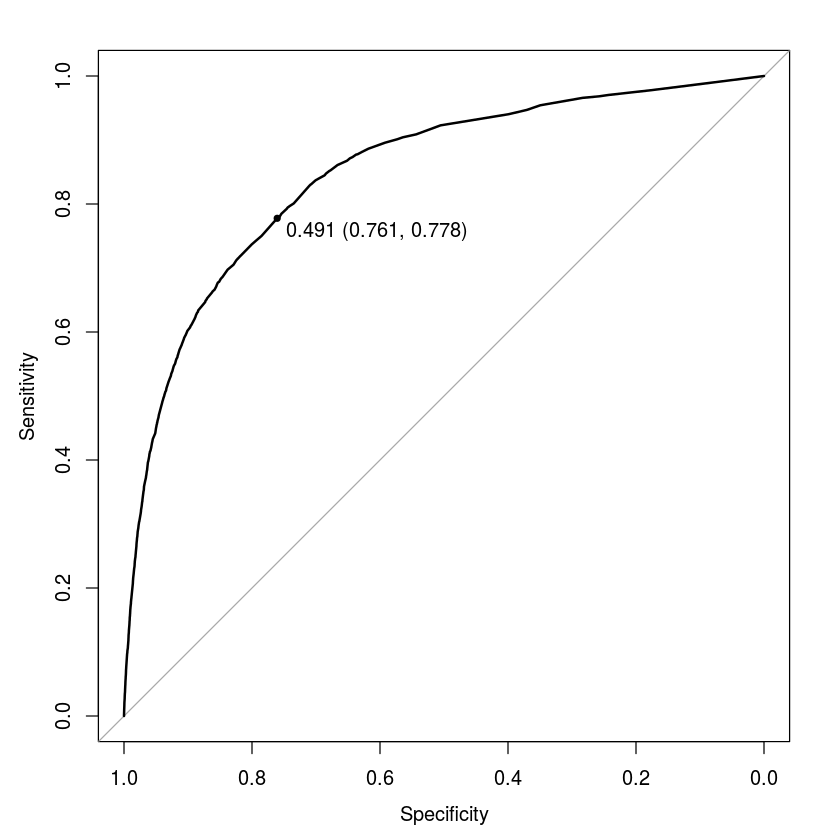

In [180]:
plot(result.roc, print.thres="best", print.thres.best.method="closest.topleft")
result.coords <- coords(result.roc, "best", best.method="closest.topleft", ret=c("threshold", "accuracy"))
print(result.coords)

# FINAL KAGGLE DATA

Now that we have our final tuned and train model, we just need to apply it to our test set.

In [134]:
final.test.df <- read.csv("cs-test.csv")

We need to apply our same cleaning and feature transformation routine to our test set:

In [135]:
#final.test.df[final.test.df$age == 0,]$age <- min(final.test.df[final.test.df$age > 0,]$age) 
final.test.df <- AddFeatures ( final.test.df )
final.test.df <- ImputeMonthlyIncomeWithZeroForAll ( final.test.df )
final.test.df <- ImputeNumberOfDependentsMean ( final.test.df )
final.test.df <- TrimHighRevolvingUtilToMedian( final.test.df ) 
final.test.df <- WinsorizeDebtRatio( final.test.df, 0.15 )
final.test.df <- ImputeWeirdPastDueWithMax( final.test.df )
final.test.df <- ExpandFeatureSpace ( final.test.df )

In [183]:
head ( final.test.df )

X,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30.59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,⋯,NeverPastDue,NoIncome,LowIncome,HighIncome,IncomeToAgeRatio,LogIncomeToAgeRatio,LogRevolvingUtilization,LogDebtRatio,NeverPastDueXNumberOfLines,NeverPastDueXRealEstate
1,NA,0.88551908,43,0,0.17751272,5700,4,0,0,⋯,1,FALSE,FALSE,FALSE,132.55814,4.887021,-0.1215813,-1.72871303,4,0
2,NA,0.46329527,57,0,0.52723693,9141,15,0,4,⋯,1,FALSE,FALSE,FALSE,160.36842,5.077474,-0.7693907,-0.64010525,15,4
3,NA,0.04327504,59,0,0.68764752,5083,12,0,1,⋯,1,FALSE,FALSE,FALSE,86.15254,4.456119,-3.1401793,-0.37447890,12,1
4,NA,0.28030823,38,1,0.92596064,3200,7,0,2,⋯,0,FALSE,FALSE,FALSE,84.21053,4.433320,-1.2718655,-0.07692355,0,0
5,NA,0.99999990,27,0,0.01991723,3865,4,0,0,⋯,1,FALSE,FALSE,FALSE,143.14815,4.963880,-0.0000001,-3.91617024,4,0
6,NA,0.50979145,63,0,0.34242936,4140,4,0,0,⋯,1,FALSE,FALSE,FALSE,65.71429,4.185316,-0.6737536,-1.07168988,4,0


In [140]:
prediction <- predict(fit, as.matrix(df[,3:length(final.test.df)]), type="prob")   # Prediction